# Modelado y Evaluación de Modelos

Este notebook contiene el proceso de preparación de datos, modelado preliminar,
evaluación con métricas seleccionadas y comparación de modelos base,
siguiendo la metodología ASUM-DM.


In [20]:
import sys
import os

# Agregar la carpeta raíz del proyecto al path
sys.path.append(os.path.abspath(".."))


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [22]:
import sys
sys.path.append("../src")

from data_preparation import preparar_datos_modelo

In [23]:
df = pd.read_csv("../data/raw/Cobertura_móvil_por_tecnología,_departamento_y_municipio_por_proveedor_20251208.csv")
df.head()


,AÑO,TRIMESTRE,PROVEEDOR,COD DEPARTAMENTO,DEPARTAMENTO,COD MUNICIPIO,MUNICIPIO,CABECERA MUNICIPAL,COD CENTRO POBLADO,CENTRO POBLADO,COBERTURA 2G,COBERTURA 3G,"COBERTURA HSPA+, HSPA+DC",COBERTUTA 4G,COBERTURA LTE,COBERTURA 5G
0,2023,3,COLOMBIA MOVIL S.A ESP,27,CHOCÓ,27250.0,EL LITORAL DEL SAN JUAN,N,27250034.0,TORDÓ,N,N,N,S,N,N
1,2023,3,COLOMBIA TELECOMUNICACIONES S.A. E.S.P.,5,ANTIOQUIA,5495.0,NECHÍ,N,5495003.0,LA CONCHA,S,S,S,S,N,N
2,2022,3,COLOMBIA MOVIL S.A ESP,70,SUCRE,70508.0,OVEJAS,N,70508006.0,DON GABRIEL,N,N,N,S,N,N
3,2021,4,AVANTEL S.A.S,73,TOLIMA,73043.0,ANZOÁTEGUI,S,73043000.0,ANZOÁTEGUI,S,S,S,N,N,N
4,2021,2,COMUNICACION CELULAR S A COMCEL S A,50,META,50150.0,CASTILLA LA NUEVA,N,50150001.0,SAN LORENZO,S,S,S,S,N,N


El dataset utilizado corresponde a información de cobertura móvil por tecnología,
departamento, municipio y proveedor.  
Este conjunto de datos fue previamente analizado en la fase de EDA.


In [24]:
from src.data_preparation import preparar_datos_modelo

X_train, X_test, y_train, y_test = preparar_datos_modelo(df)

print("Datos preparados correctamente")
print(X_train.shape, X_test.shape)



Datos preparados correctamente
(285096, 8166) (122185, 8166)


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [50, 80],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,          # 🔴 MUY IMPORTANTE
    cv=2,              # 🔴 BAJO
    scoring="accuracy",
    verbose=2,
    random_state=42
)

In [26]:
random_search.fit(X_train, y_train)



Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  21.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  26.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  26.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  26.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  26.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  31.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  29.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=  41.8s
[CV] END max_depth=20, min_samples_leaf=

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [10, 20], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [50, 80]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",5
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.2

In [27]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)


Mejores hiperparámetros encontrados:
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}


In [28]:
modelo = random_search.best_estimator_


## Resultados finales del modelo


       Cobertura_real Cobertura_predicha  Probabilidad_cobertura_4G
0                   N                  N                   0.145259
1                   N                  N                   0.127772
2                   N                  N                   0.113319
3                   N                  N                   0.144104
4                   N                  N                   0.171151
...               ...                ...                        ...
122180              N                  N                   0.137211
122181              S                  N                   0.303268
122182              N                  N                   0.228545
122183              S                  N                   0.262714
122184              N                  N                   0.174803

[122185 rows x 3 columns]
Evaluación del modelo final:
              precision    recall  f1-score   support

           N       0.82      1.00      0.90     99650
           S       

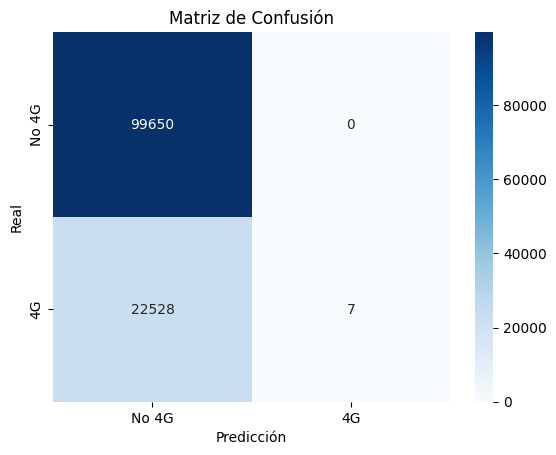

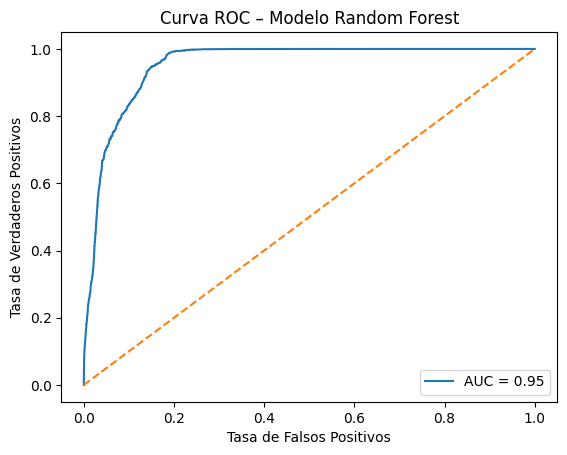

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Predicciones
y_pred = modelo.predict(X_test)

y_proba = modelo.predict_proba(X_test)
proba_4g = y_proba[:, 1]

# Resultados
resultados = pd.DataFrame({
    "Cobertura_real": y_test.values,
    "Cobertura_predicha": y_pred,
    "Probabilidad_cobertura_4G": proba_4g
})

resultados.head(10)

print(resultados)

print("Evaluación del modelo final:")
# Reporte
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No 4G", "4G"],
    yticklabels=["No 4G", "4G"]
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC
y_proba2 = modelo.predict_proba(X_test)[:, 1]  # SOLO clase "S"

fpr, tpr, _ = roc_curve(y_test, y_proba2, pos_label="S")
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC – Modelo Random Forest")
plt.legend()
plt.show()